In [2]:
import os
import cv2
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from multiprocessing import Pool
from mpl_toolkits.basemap import Basemap

In [3]:
# The base dir where all CSVs are stored (for which you want to make a timelapse)

dataset_base_dir = '/home/adwait_bhope/Desktop/Files/Hackathons/ASEAN India Hackathon 2020/data/playing around/100th degree/2016'
files = sorted(os.listdir(dataset_base_dir))
print(files[:5])
print(len(files))

['2016-01-01.csv', '2016-01-02.csv', '2016-01-03.csv', '2016-01-04.csv', '2016-01-05.csv']
367


In [4]:
sample_df = pd.read_csv(os.path.join(dataset_base_dir, files[0]))
sample_df.head()

,date,lat_bin,lon_bin,flag,geartype,vessel_hours,fishing_hours,mmsi_present
0,2016-01-01,1280,-1770,ITA,trawlers,0.297500,0.000000,1
1,2016-01-01,1280,-1736,GRC,trawlers,0.260833,0.000000,1
2,2016-01-01,2304,11704,CHN,trawlers,0.275556,0.275556,1
3,2016-01-01,2304,11694,CHN,trawlers,0.354861,0.354861,1
4,2016-01-01,2304,11702,CHN,trawlers,0.458750,0.458750,1


In [18]:
# Store the number of vessel_hours from all CSVs to combine them into one single DataFrame

vessel_hours = {}
fishing_hours = {}

for file in tqdm(files):
    df = pd.read_csv(os.path.join(dataset_base_dir, file))
    
    for row in df.itertuples():
        grid = (row.lat_bin, row.lon_bin)

        if grid in vessel_hours:
            vessel_hours[grid] += row.vessel_hours
            fishing_hours[grid] += row.fishing_hours
        else:
            vessel_hours[grid] = row.vessel_hours
            fishing_hours[grid] = row.fishing_hours
            
print(len(vessel_hours), len(fishing_hours))

  4%|▍         | 16/367 [00:08<03:05,  1.89it/s]


KeyboardInterrupt: 

In [19]:
# Create a DataFrame that contains data from all CSVs

rows = []
for grid in tqdm(vessel_hours):
    row = {
        'lat_bin': grid[0],
        'lon_bin': grid[1],
        'vessel_hours': vessel_hours[grid],
        'fishing_hours': fishing_hours[grid]
    }
    
    rows.append(row)
    
parent_df = pd.DataFrame(rows)

100%|██████████| 1427104/1427104 [00:01<00:00, 751736.04it/s]


In [20]:
min_fishing_hours = min(parent_df["fishing_hours"])
max_fishing_hours = max(parent_df["fishing_hours"])

print('Length:', len(parent_df), '\n')
print(f'Min fishing hours: {min_fishing_hours:.2f}')
print(f'Max fishing hours: {max_fishing_hours:.2f}\n')
print(f'Min vessel hours: {min(parent_df["vessel_hours"]):.2f}')
print(f'Max vessel hours: {max(parent_df["vessel_hours"]):.2f}')

Length: 1427104 

Min fishing hours: 0.00
Max fishing hours: 240.06

Min vessel hours: 0.00
Max vessel hours: 15009.27


In [13]:
fishing_hours_series = parent_df["fishing_hours"]
sorted_fishing_hours = fishing_hours_series.sort_values()
print(sorted_fishing_hours)

In [14]:
sorted_fishing_hours.value_counts()

In [15]:
sorted_fishing_hours.sort_values()

0           0.000000
114542      0.000000
257995      0.000000
257996      0.000000
114541      0.000000
             ...    
10777      91.813333
211605     98.351528
4597      101.566250
12852     117.512083
71636     120.770139
Name: fishing_hours, Length: 1153124, dtype: float64

No handles with labels found to put in legend.
/home/adwait_bhope/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


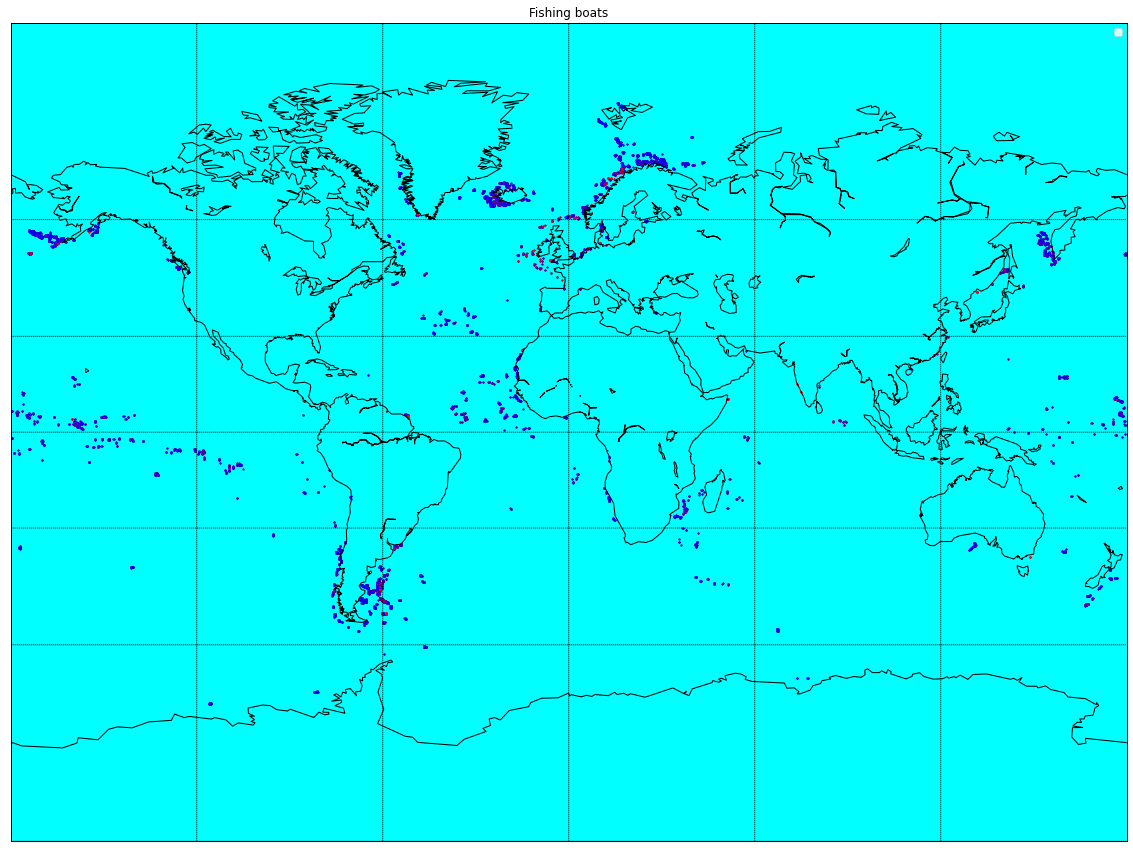

In [63]:
# Draw a plot of all points from parent_df

plt.figure(figsize=(20, 20))

m = Basemap(projection='mill',llcrnrlat=-90,urcrnrlat=90,\
            llcrnrlon=-180,urcrnrlon=180,resolution='c')
m.drawcoastlines()
# m.fillcontinents(color='orange',lake_color='aqua')

# draw parallels and meridians.
m.drawparallels(np.arange(-90.,91.,30.))
m.drawmeridians(np.arange(-180.,181.,60.))
m.drawmapboundary(fill_color='aqua')

# reds = []

counter = 0

for i, row in enumerate(parent_df.itertuples()):
    x, y = m(row.lon_bin / 100, row.lat_bin / 100)

    if round(row.fishing_hours) == 0:
        continue
    
    counter += 1
        
    color_value = math.floor(np.interp(row.fishing_hours, [0, 15], [0, 255]))
    
    red = hex(color_value).split('x')[-1].upper()
    if len(red) == 1:
        red = '0' + red
        
    blue = hex(255 - color_value).split('x')[-1].upper()
    if len(blue) == 1:
        blue = '0' + blue    
        
    color = f'#{red}00{blue}'
    
    m.scatter(x, y, color=color, marker='D', s=np.pi / 2)
    if counter == 10000:
        break
    
plt.title("Fishing boats")
plt.legend()
plt.show()

No handles with labels found to put in legend.


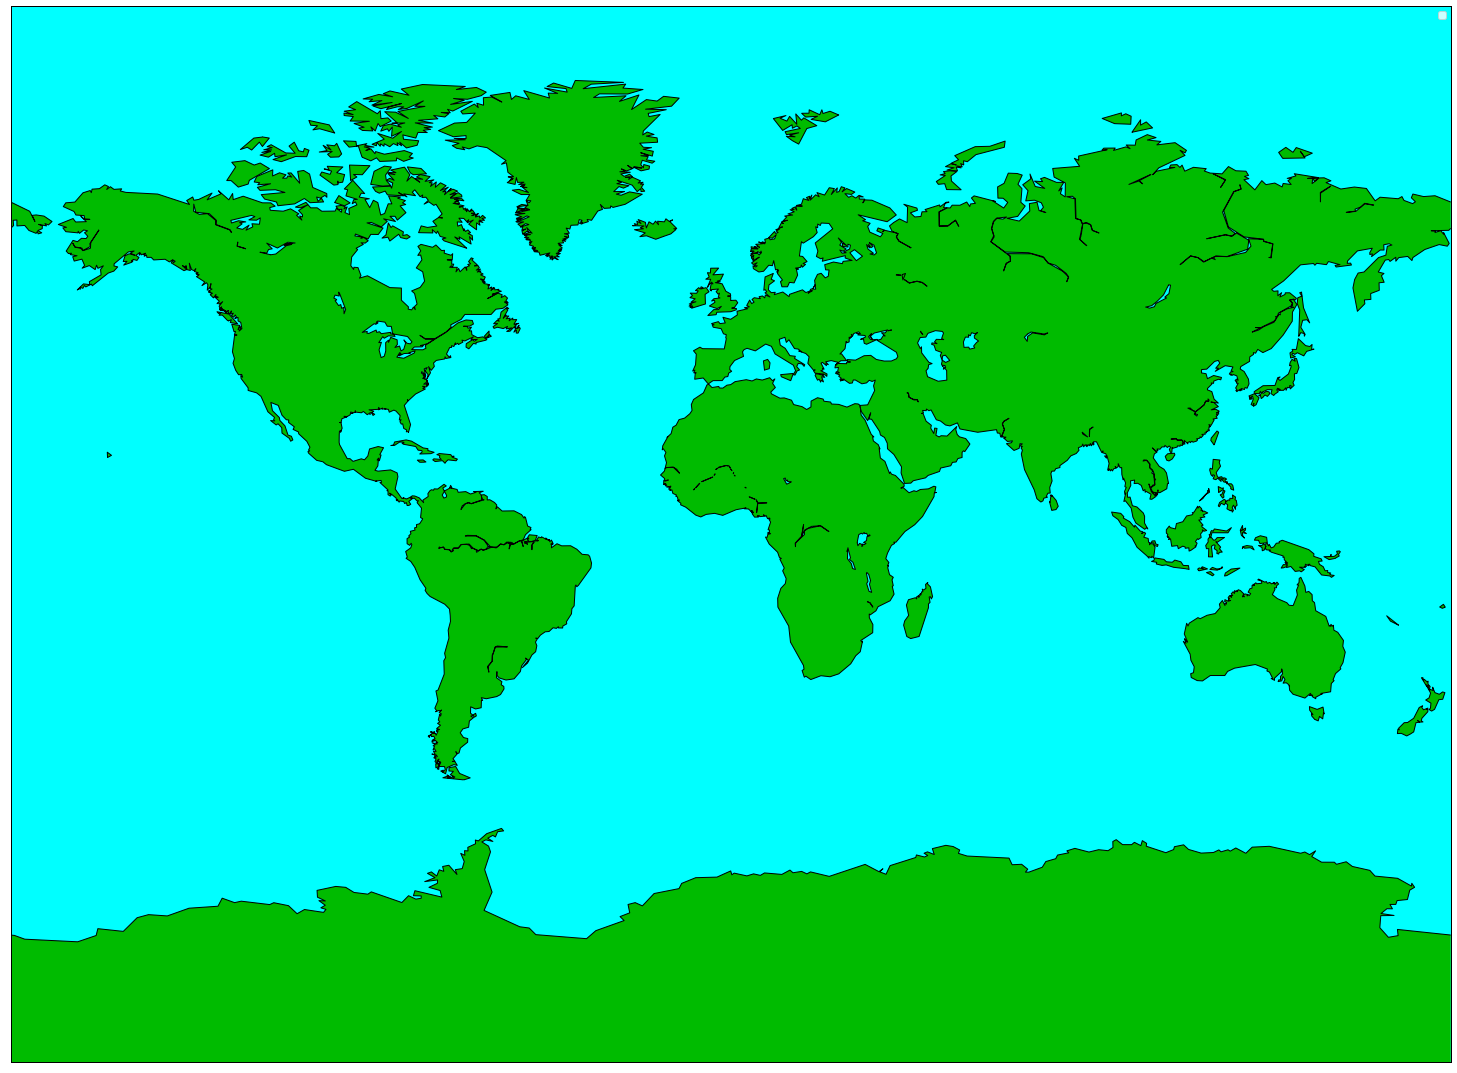

In [5]:
# Generates and saves a basemap to the disk as a PNG
# This PNG file is used for coloring the points using OpenCV so we can create a timelapse

plt.figure(figsize=(20, 20))

m = Basemap(projection='mill',llcrnrlat=-90,urcrnrlat=90,\
            llcrnrlon=-180,urcrnrlon=180,resolution='c')
m.drawcoastlines()
m.fillcontinents(color='#00BB00', lake_color='aqua')

# draw parallels and meridians.
# m.drawparallels(np.arange(-90.,91.,30.))
# m.drawmeridians(np.arange(-180.,181.,60.))
m.drawmapboundary(fill_color='aqua')

#     m.scatter(x, y, color=color, marker='D', s=np.pi / 2)
    
# plt.title("Fishing boats")
plt.legend()
# plt.show()

# plt.gca().set_axis_off()
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
plt.margins(0, 0)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())

DPI = 180
plt.savefig(f'world_map_{DPI}dpi.png', dpi=DPI, bbox_inches = 'tight', pad_inches = 0)

In [ ]:
# Trying to plot the number of fishing_hours to help decide the color mapping scale
# Current scale is 0 to 15 hours -> blue to red color
# 0 hours = Completely Blue - RGB: (0, 0, 255)
# 15 hours = Completely Red - RGB: (255, 0, 0)
# 7.5 hours = RGB: (127, 0, 127)
# Clearly, for a linear mapping, R = 255 - B

small_fishing_hours_series = fishing_hours_series[:-100]
small_fishing_hours_series.plot.bar()

In [11]:
MIN_FISHING_HOURS = 0
MAX_FISHING_HOURS = 5

In [9]:
# Just checking the result of the function m() to see if we can map the output linearly to pixel coordinates
# Answer is yes

print(m(-180, 0))
print(m(0, 0))
print(m(+180, 0))
print()
print(m(0, -90))
print(m(0, 0))
print(m(0, +90))

(0.0, 14675034.4036134)
(20015077.371242613, 14675034.4036134)
(40030154.742485225, 14675034.4036134)

(20015077.371242613, 4.0978193283081055e-08)
(20015077.371242613, 14675034.4036134)
(20015077.371242613, 29350068.807226755)


In [10]:
# Setting up min and max values of the lat-lon range after passing it through m()
# Used to create a linear mapping between these values and pixel coordinates

min_lon, min_lat = m(-180, -90)
max_lon, max_lat = m(+180, +90)

print()
print(min_lat, max_lat)
print(min_lon, max_lon)


4.0978193283081055e-08 29350068.807226755
0.0 40030154.742485225


In [58]:
# NOT NECESSARY TO RUN

# This cell plots lat-lon coordinates on a world map which is an image (using OpenCV)

world_map = cv2.imread(f'world_map_{DPI}dpi.png')

for i, row in tqdm(enumerate(parent_df.itertuples())):
    lon, lat = m(row.lon_bin / 100, row.lat_bin / 100)

    lon = math.floor(np.interp(lon, [min_lon, max_lon], [0, width]))
    lat = math.floor(np.interp(lat, [min_lat, max_lat], [height, 0]))
    
    red = math.floor(np.interp(row.fishing_hours, [MIN_FISHING_HOURS, MAX_FISHING_HOURS], [0, 255]))
    blue = 255 - color_value

    world_map[lat, lon] = np.array([blue, 0, red])
    
# Save the image to disk
cv2.imwrite('Heat map.png', world_map)

1153124it [00:50, 23045.10it/s]


# Generating individual frames for all CSVs

In [13]:
BASEMAP = f'world_map_{DPI}dpi.png'
IMAGE_OUTPUT_DIR = os.path.join(os.getcwd(), 'Images2016')

if not os.path.isdir(IMAGE_OUTPUT_DIR):
    os.mkdir(IMAGE_OUTPUT_DIR)

world_map_org = cv2.imread(BASEMAP)
height, width, _ = world_map_org.shape

In [14]:
# This function generates individual frames and saves them to disk
# These frames can be stitched together into a video at any time

def generate_frame_from_csv(file):
    df = pd.read_csv(os.path.join(dataset_base_dir, file))
    world_map = world_map_org.copy()

    for i, row in enumerate(df.itertuples()):
        lon, lat = m(row.lon_bin / 100, row.lat_bin / 100)

        lon = math.floor(np.interp(lon, [min_lon, max_lon], [0, width]))
        lat = math.floor(np.interp(lat, [min_lat, max_lat], [height, 0]))

        red = math.floor(np.interp(row.fishing_hours, [MIN_FISHING_HOURS, MAX_FISHING_HOURS], [0, 255]))
        blue = 255 - red

        world_map[lat, lon] = np.array([blue, 0, red])

    world_map = cv2.putText(world_map, os.path.splitext(file)[0], (50, 100), cv2.FONT_HERSHEY_SIMPLEX , 2, (0, 0, 0), 1, cv2.LINE_AA)

    cv2.imwrite(os.path.join(IMAGE_OUTPUT_DIR, os.path.splitext(file)[0] + '.png'), world_map)

In [ ]:
# Using multiprocessing to speed this up

# Can also remove the -1 from the below line for maximum possible speed, but it might freeze the system
num_threads = os.cpu_count() - 1

with Pool(num_threads) as p:
    _ = list(tqdm(p.imap(generate_frame_from_csv, files), total=len(files)))


# Generate video from existing frames

In [16]:
FPS = 4
VIDEO_NAME = f'Fishing Effort Timelapse 2016 {FPS}fps.mp4'

In [17]:
out = cv2.VideoWriter(VIDEO_NAME, cv2.VideoWriter_fourcc(*'MJPG'), FPS, (width, height))

for file in tqdm(sorted(os.listdir(IMAGE_OUTPUT_DIR))):
    frame = cv2.imread(os.path.join(IMAGE_OUTPUT_DIR, file))
    
    try:
        out.write(frame.astype('uint8'))
    except AttributeError:
        print('Error with file:', file)

out.release()

100%|██████████| 17/17 [00:03<00:00,  4.51it/s]
